In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cebra
from cebra import CEBRA 
from cebra.datasets import init as dataset_init

In [2]:
# 加载包含所有数据的数据集 (active + passive)
dataset = dataset_init("area2-bump")
pos_dataset_all = dataset_init("area2-bump-pos-all")
target_dataset_all = dataset_init("area2-bump-target-all")
posdir_dataset_all = dataset_init("area2-bump-posdir-all")

# 数据集验证函数
def validate_dataset(dataset, name):
    """验证数据集基本信息"""
    print(f"\n{name} Dataset Info:")
    print(f"Total length: {len(dataset)}")
    if hasattr(dataset, 'neural'):
        print(f"Neural data shape: {dataset.neural.shape}")
    if hasattr(dataset, 'continuous_index') and dataset.continuous_index is not None:
        print(f"Continuous labels shape: {dataset.continuous_index.shape}")
    if hasattr(dataset, 'discrete_index') and dataset.discrete_index is not None:
        print(f"Discrete labels shape: {dataset.discrete_index.shape}")

# 验证加载的数据集
validate_dataset(dataset, "Base")
validate_dataset(pos_dataset_all, "Position")
validate_dataset(target_dataset_all, "Target")
validate_dataset(posdir_dataset_all, "Position-Direction")


Base Dataset Info:
Total length: 115800
Neural data shape: torch.Size([115800, 65])
Continuous labels shape: torch.Size([115800, 2])
Discrete labels shape: torch.Size([115800])

Position Dataset Info:
Total length: 218400
Neural data shape: torch.Size([218400, 65])
Continuous labels shape: torch.Size([218400, 2])

Target Dataset Info:
Total length: 218400
Neural data shape: torch.Size([218400, 65])
Discrete labels shape: torch.Size([218400])

Position-Direction Dataset Info:
Total length: 218400
Neural data shape: torch.Size([218400, 65])
Continuous labels shape: torch.Size([218400, 2])
Discrete labels shape: torch.Size([218400])


In [3]:
# 假设每个trial长度为600个时间点
trial_length = 600
n_trials = len(pos_dataset_all) // trial_length

print(f"Total trials: {n_trials}")

def get_active_passive_split(dataset, trial_length, proportion=0.5):
    """将数据集分割为active和passive部分
    
    Args:
        dataset: 要分割的数据集
        trial_length: 每个trial的长度
        proportion: active部分的比例，默认为0.5（一半）
    
    Returns:
        active_data, passive_data
    """
    n_trials = len(dataset) // trial_length
    split_point = int(n_trials * proportion)
    split_index = split_point * trial_length
    
    return dataset[:split_index], dataset[split_index:]

# 分割神经数据和标签
active_neural, passive_neural = get_active_passive_split(pos_dataset_all.neural, trial_length)
active_pos, passive_pos = get_active_passive_split(pos_dataset_all.continuous_index, trial_length)
active_target, passive_target = get_active_passive_split(target_dataset_all.discrete_index, trial_length)

# 打印分割后的数据形状
print(f"Active neural data shape: {active_neural.shape}")
print(f"Passive neural data shape: {passive_neural.shape}")
print(f"Active position labels shape: {active_pos.shape}")
print(f"Passive position labels shape: {passive_pos.shape}")
print(f"Active target labels shape: {active_target.shape}")
print(f"Passive target labels shape: {passive_target.shape}")

Total trials: 364
Active neural data shape: torch.Size([109200, 65])
Passive neural data shape: torch.Size([109200, 65])
Active position labels shape: torch.Size([109200, 2])
Passive position labels shape: torch.Size([109200, 2])
Active target labels shape: torch.Size([109200])
Passive target labels shape: torch.Size([109200])


In [4]:
# 创建模型函数
def create_cebra_model(output_dim=3, max_iter=15000):
    return CEBRA(
        model_architecture='offset10-model',
        batch_size=512,
        learning_rate=0.0001,
        temperature=1,
        output_dimension=output_dim,
        max_iterations=max_iter,
        distance='cosine',
        conditional='time_delta',
        device='cuda_if_available',
        verbose=True,
        time_offsets=10
    )

# 创建位置模型
active_pos_model = create_cebra_model()
passive_pos_model = create_cebra_model()

# 创建目标方向模型
active_target_model = create_cebra_model()
passive_target_model = create_cebra_model()

In [5]:
# 训练 Active 位置模型
print("Training Active Position Model...")
active_pos_model.fit(active_neural, active_pos.numpy())
active_pos_embedding = active_pos_model.transform(active_neural)

# 训练 Passive 位置模型
print("\nTraining Passive Position Model...")
passive_pos_model.fit(passive_neural, passive_pos.numpy())
passive_pos_embedding = passive_pos_model.transform(passive_neural)

Training Active Position Model...


pos: -0.7114 neg:  6.4594 total:  5.7479 temperature:  1.0000: 100%|██████████| 15000/15000 [02:40<00:00, 93.30it/s] 



Training Passive Position Model...


pos: -0.7567 neg:  6.4661 total:  5.7094 temperature:  1.0000: 100%|██████████| 15000/15000 [02:57<00:00, 84.54it/s] 


In [6]:
# 训练 Active 目标方向模型
print("Training Active Target Model...")
active_target_model.fit(active_neural, active_target.numpy())
active_target_embedding = active_target_model.transform(active_neural)

# 训练 Passive 目标方向模型
print("\nTraining Passive Target Model...")
passive_target_model.fit(passive_neural, passive_target.numpy())
passive_target_embedding = passive_target_model.transform(passive_neural)

Training Active Target Model...


pos: -0.4244 neg:  6.4228 total:  5.9984 temperature:  1.0000: 100%|██████████| 15000/15000 [03:30<00:00, 71.12it/s]



Training Passive Target Model...


pos: -0.4961 neg:  6.4286 total:  5.9325 temperature:  1.0000: 100%|██████████| 15000/15000 [03:14<00:00, 77.06it/s]


In [7]:
def plot_embeddings(active_emb, passive_emb, active_labels, passive_labels, title, cmap='seismic', 
                   vmin=None, vmax=None, figsize=(12, 5), alpha=0.7, point_size=0.05):
    """绘制对比可视化图
    
    Args:
        active_emb: Active数据的嵌入
        passive_emb: Passive数据的嵌入
        active_labels: Active数据的标签（用于着色）
        passive_labels: Passive数据的标签（用于着色）
        title: 图表标题
        cmap: 颜色映射
        vmin, vmax: 颜色映射的最小值和最大值
        figsize: 图表大小
        alpha: 点的透明度
        point_size: 点的大小
    """
    fig = plt.figure(figsize=figsize)
    plt.suptitle(f'CEBRA {title} Embeddings: Active vs Passive', fontsize=20)
    
    # Active
    ax = plt.subplot(121, projection='3d')
    ax.set_title('Active Trials', fontsize=15)
    scatter = ax.scatter(active_emb[:, 0],
                        active_emb[:, 1],
                        active_emb[:, 2],
                        c=active_labels,
                        cmap=cmap,
                        s=point_size,
                        alpha=alpha,
                        vmin=vmin,
                        vmax=vmax)
    ax.axis('off')
    
    # Passive
    ax = plt.subplot(122, projection='3d')
    ax.set_title('Passive Trials', fontsize=15)
    scatter = ax.scatter(passive_emb[:, 0],
                        passive_emb[:, 1],
                        passive_emb[:, 2],
                        c=passive_labels,
                        cmap=cmap,
                        s=point_size,
                        alpha=alpha,
                        vmin=vmin,
                        vmax=vmax)
    ax.axis('off')
    
    cbar = plt.colorbar(scatter)
    if title == 'Target Direction':
        cbar.set_label('Direction')
    else:
        cbar.set_label('Position (cm)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

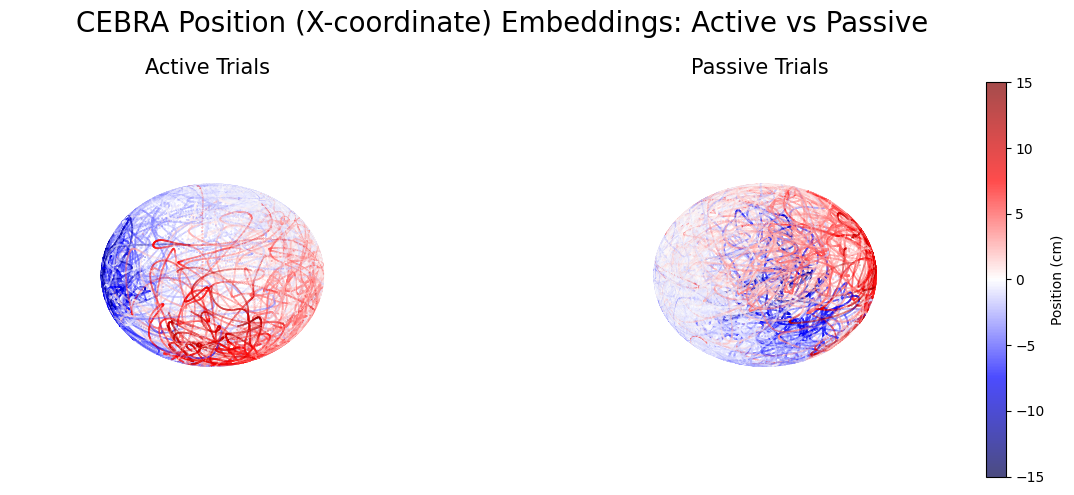

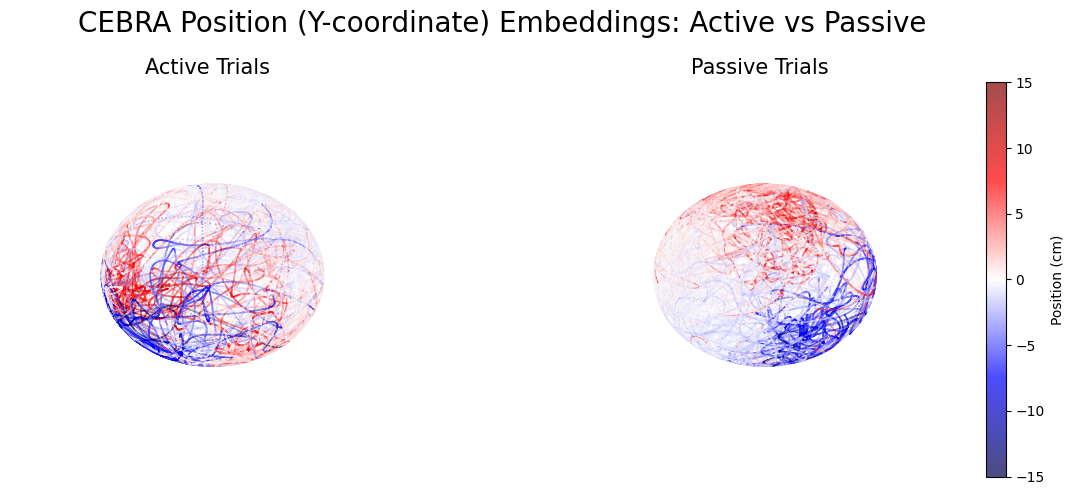

In [8]:
# 绘制位置模型的嵌入结果（使用x坐标着色）
position_fig = plot_embeddings(
    active_pos_embedding,
    passive_pos_embedding,
    active_pos[:, 0],  # 使用x坐标作为颜色
    passive_pos[:, 0],
    'Position (X-coordinate)',
    cmap='seismic',
    vmin=-15,
    vmax=15
)
# 绘制位置模型的嵌入结果（使用y坐标着色）
position_y_fig = plot_embeddings(
    active_pos_embedding,
    passive_pos_embedding,
    active_pos[:, 1],  # 使用y坐标作为颜色
    passive_pos[:, 1],
    'Position (Y-coordinate)',
    cmap='seismic',
    vmin=-15,
    vmax=15
)

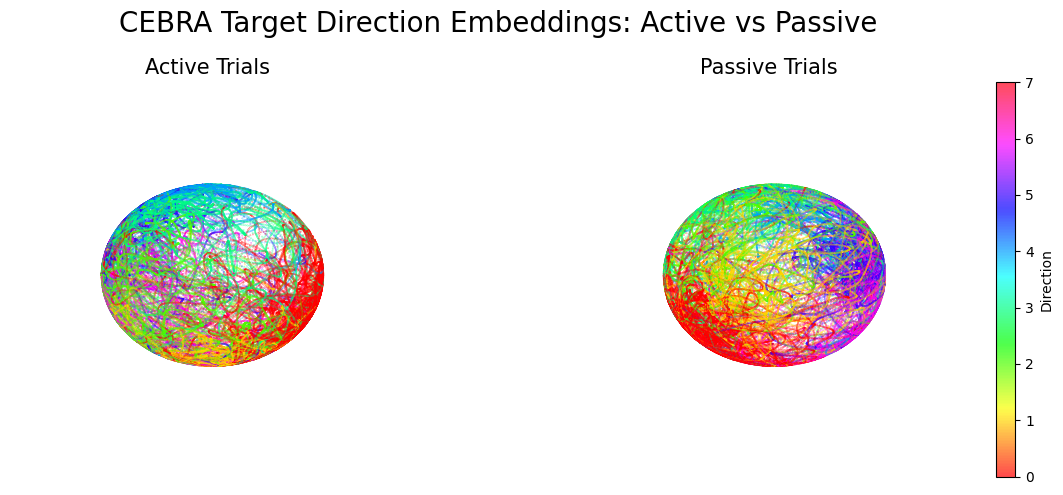

In [9]:
# 绘制目标方向模型的嵌入结果
target_fig = plot_embeddings(
    active_target_embedding,
    passive_target_embedding,
    active_target.flatten(),
    passive_target.flatten(),
    'Target Direction',
    cmap='hsv',
    vmin=0,
    vmax=7  # 8个方向，索引0-7
)

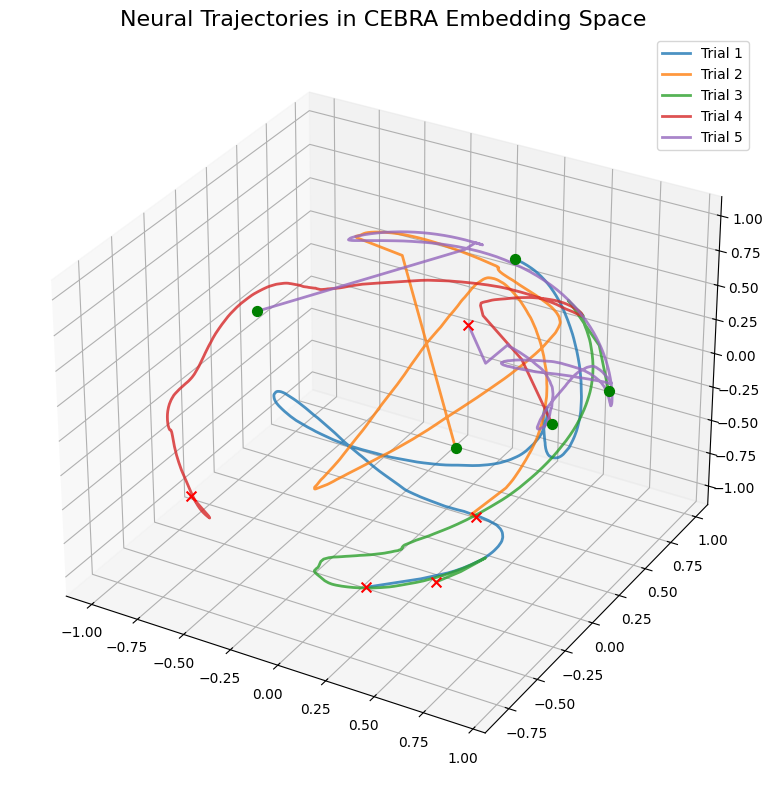

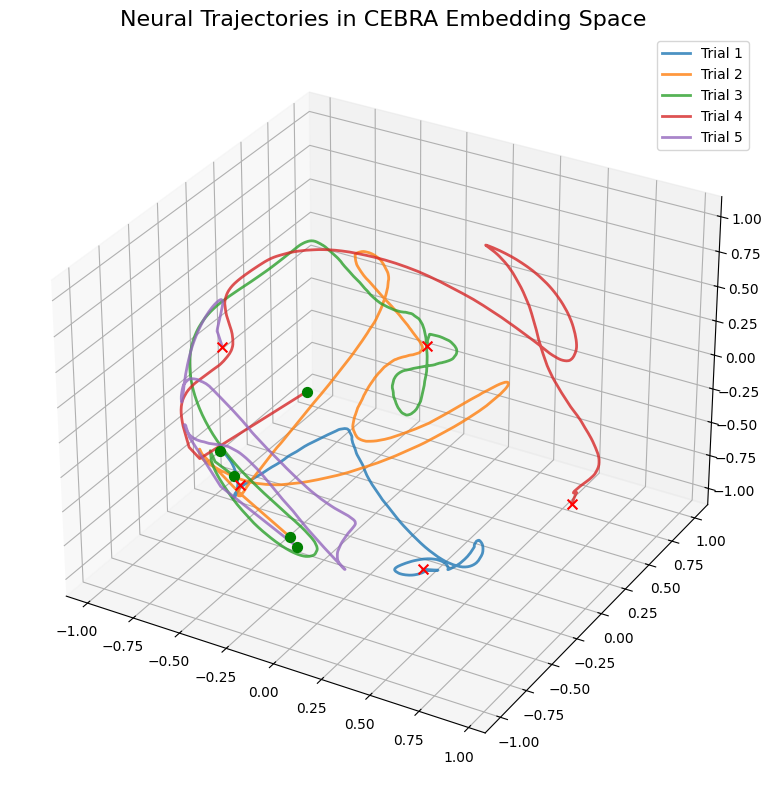

In [10]:
def plot_trajectories(embedding, trial_length=600, n_trials=5, figsize=(10, 8)):
    """在嵌入空间中可视化神经轨迹
    
    Args:
        embedding: 嵌入结果
        trial_length: 每个trial的长度
        n_trials: 要可视化的trial数量
        figsize: 图表大小
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # 将嵌入重塑为(n_trials, trial_length, 3)
    trials = embedding[:n_trials*trial_length].reshape(-1, trial_length, 3)
    
    # 为每个trial绘制轨迹
    for i in range(n_trials):
        trial = trials[i]
        ax.plot(trial[:, 0], trial[:, 1], trial[:, 2], 
                linewidth=2, alpha=0.8, label=f'Trial {i+1}')
        
        # 标记起点和终点
        ax.scatter(trial[0, 0], trial[0, 1], trial[0, 2], 
                  c='green', s=50, marker='o', label='_nolegend_')
        ax.scatter(trial[-1, 0], trial[-1, 1], trial[-1, 2], 
                  c='red', s=50, marker='x', label='_nolegend_')
    
    ax.set_title('Neural Trajectories in CEBRA Embedding Space', fontsize=16)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return fig

# 绘制Active位置模型的轨迹
active_trajectories = plot_trajectories(active_pos_embedding)

# 绘制Passive位置模型的轨迹
passive_trajectories = plot_trajectories(passive_pos_embedding)

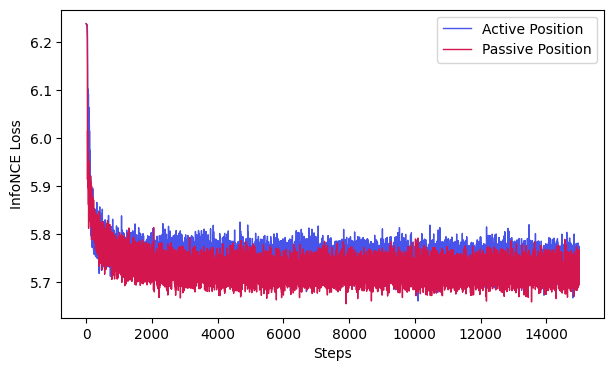

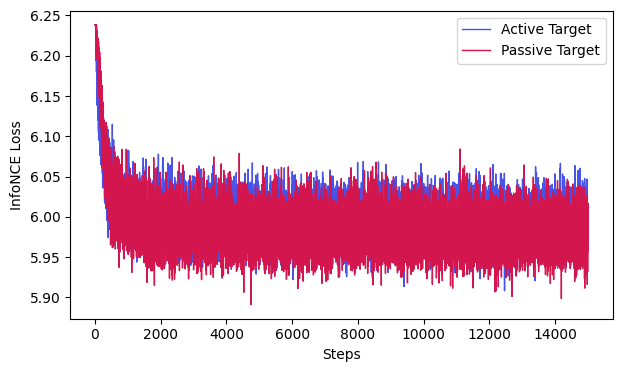

In [11]:
# 比较Active和Passive数据的模型性能
import cebra

# 比较位置模型
pos_comparison = cebra.compare_models(
    [active_pos_model, passive_pos_model], 
    ["Active Position", "Passive Position"]
)

# 比较目标方向模型
target_comparison = cebra.compare_models(
    [active_target_model, passive_target_model], 
    ["Active Target", "Passive Target"]
)

In [12]:
# 保存嵌入结果
output_file = 'result/monkey_reaching_all_embeddings.npz'

np.savez(
    output_file,
    active_pos_embedding=active_pos_embedding,
    passive_pos_embedding=passive_pos_embedding,
    active_target_embedding=active_target_embedding,
    passive_target_embedding=passive_target_embedding,
    active_pos=active_pos.numpy(),
    passive_pos=passive_pos.numpy(),
    active_target=active_target.numpy(),
    passive_target=passive_target.numpy()
)

print(f"结果已保存到 {output_file}")

结果已保存到 result/monkey_reaching_all_embeddings.npz


In [13]:
def compute_model_consistency(model1, model2, data1, data2, labels1=None, labels2=None, n_runs=2):
    """计算两个模型之间的一致性得分"""
    
    def preprocess_labels(labels):
        """预处理标签"""
        if labels is None:
            return None
        # 确保是1D数组
        if len(labels.shape) > 1:
            labels = labels[:, 0]
        # 转换为numpy数组
        if not isinstance(labels, np.ndarray):
            labels = np.array(labels)
        return labels

    def normalize_labels(labels1, labels2):
        """标准化标签"""
        # 计算全局统计量
        all_labels = np.concatenate([labels1, labels2])
        mean = np.mean(all_labels)
        std = np.std(all_labels)
        
        # Z-score标准化
        labels1_norm = (labels1 - mean) / (std + 1e-8)
        labels2_norm = (labels2 - mean) / (std + 1e-8)
        
        return labels1_norm, labels2_norm

    # 预处理标签
    labels1_proc = preprocess_labels(labels1)
    labels2_proc = preprocess_labels(labels2)
    
    embeddings_runs1 = []
    embeddings_runs2 = []
    
    # 多次运行每个模型
    for i in range(n_runs):
        print(f"Run {i+1}/{n_runs} for model1...")
        embeddings_runs1.append(model1.fit_transform(data1, labels1))
        print(f"Run {i+1}/{n_runs} for model2...")
        embeddings_runs2.append(model2.fit_transform(data2, labels2))
    
    # 计算运行间的一致性
    scores_runs1, pairs_runs1, ids_runs1 = cebra.sklearn.metrics.consistency_score(
        embeddings=embeddings_runs1,
        between="runs"
    )
    
    scores_runs2, pairs_runs2, ids_runs2 = cebra.sklearn.metrics.consistency_score(
        embeddings=embeddings_runs2,
        between="runs"
    )
    
    # 计算数据集间的一致性
    if labels1_proc is not None and labels2_proc is not None:
        try:
            # 标准化标签
            labels1_norm, labels2_norm = normalize_labels(labels1_proc, labels2_proc)
            
            # 检查标签分布
            print("\nLabel distribution statistics:")
            print(f"Labels1 - mean: {np.mean(labels1_norm):.3f}, std: {np.std(labels1_norm):.3f}")
            print(f"Labels2 - mean: {np.mean(labels2_norm):.3f}, std: {np.std(labels2_norm):.3f}")
            
            scores_datasets, pairs_datasets, ids_datasets = cebra.sklearn.metrics.consistency_score(
                embeddings=[embeddings_runs1[0], embeddings_runs2[0]],
                labels=[labels1_norm, labels2_norm],
                dataset_ids=["Active", "Passive"],
                between="datasets",
                num_discretization_bins=20  # 减少bin数量
            )
        except Exception as e:
            print(f"\nError in dataset consistency calculation: {e}")
            print("Attempting alternative binning strategy...")
            try:
                # 尝试使用分位数离散化
                from sklearn.preprocessing import KBinsDiscretizer
                discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
                labels_combined = np.concatenate([labels1_norm, labels2_norm])
                discretizer.fit(labels_combined.reshape(-1, 1))
                
                labels1_disc = discretizer.transform(labels1_norm.reshape(-1, 1)).flatten()
                labels2_disc = discretizer.transform(labels2_norm.reshape(-1, 1)).flatten()
                
                scores_datasets, pairs_datasets, ids_datasets = cebra.sklearn.metrics.consistency_score(
                    embeddings=[embeddings_runs1[0], embeddings_runs2[0]],
                    labels=[labels1_disc, labels2_disc],
                    dataset_ids=["Active", "Passive"],
                    between="datasets"
                )
            except Exception as e2:
                print(f"Alternative binning also failed: {e2}")
                scores_datasets, pairs_datasets, ids_datasets = None, None, None
    else:
        scores_datasets, pairs_datasets, ids_datasets = None, None, None
    
    return {
        'runs1': (scores_runs1, pairs_runs1, ids_runs1),
        'runs2': (scores_runs2, pairs_runs2, ids_runs2),
        'datasets': (scores_datasets, pairs_datasets, ids_datasets),
        'embeddings1': embeddings_runs1[0],
        'embeddings2': embeddings_runs2[0]
    }

In [14]:
# 位置标签使用第一列（x坐标）
active_pos_1d = active_pos[:, 0]
passive_pos_1d = passive_pos[:, 0]

# 目标标签应该已经是1D的，但我们确保一下
if len(active_target.shape) > 1:
    active_target_1d = active_target[:, 0]
else:
    active_target_1d = active_target

if len(passive_target.shape) > 1:
    passive_target_1d = passive_target[:, 0]
else:
    passive_target_1d = passive_target

# 计算位置模型的一致性（Active vs Passive）
pos_consistency = compute_model_consistency(
    active_pos_model,
    passive_pos_model,
    active_neural,
    passive_neural,
    active_pos_1d.numpy(),
    passive_pos_1d.numpy(),
    n_runs=2  # 减少运行次数以节省时间
)

# 计算目标方向模型的一致性
target_consistency = compute_model_consistency(
    active_target_model,
    passive_target_model,
    active_neural,
    passive_neural,
    active_target_1d.numpy(),
    passive_target_1d.numpy(),
    n_runs=2  # 减少运行次数以节省时间
)

Run 1/2 for model1...


pos: -0.6876 neg:  6.5746 total:  5.8870 temperature:  1.0000: 100%|██████████| 15000/15000 [03:11<00:00, 78.45it/s] 


Run 1/2 for model2...


pos: -0.6577 neg:  6.5764 total:  5.9187 temperature:  1.0000: 100%|██████████| 15000/15000 [03:13<00:00, 77.49it/s] 


Run 2/2 for model1...


pos: -0.6468 neg:  6.5885 total:  5.9418 temperature:  1.0000: 100%|██████████| 15000/15000 [03:13<00:00, 77.72it/s]


Run 2/2 for model2...


pos: -0.6967 neg:  6.5555 total:  5.8588 temperature:  1.0000: 100%|██████████| 15000/15000 [03:12<00:00, 77.80it/s]



Label distribution statistics:
Labels1 - mean: 0.010, std: 1.019
Labels2 - mean: -0.010, std: 0.980
Run 1/2 for model1...


pos: -0.4471 neg:  6.4216 total:  5.9746 temperature:  1.0000: 100%|██████████| 15000/15000 [03:09<00:00, 79.00it/s]


Run 1/2 for model2...


pos: -0.4411 neg:  6.4256 total:  5.9845 temperature:  1.0000: 100%|██████████| 15000/15000 [03:29<00:00, 71.57it/s]


Run 2/2 for model1...


pos: -0.4599 neg:  6.4223 total:  5.9624 temperature:  1.0000: 100%|██████████| 15000/15000 [03:23<00:00, 73.64it/s] 


Run 2/2 for model2...


pos: -0.4488 neg:  6.4378 total:  5.9891 temperature:  1.0000: 100%|██████████| 15000/15000 [02:55<00:00, 85.71it/s] 



Label distribution statistics:
Labels1 - mean: -0.045, std: 1.006
Labels2 - mean: 0.045, std: 0.992


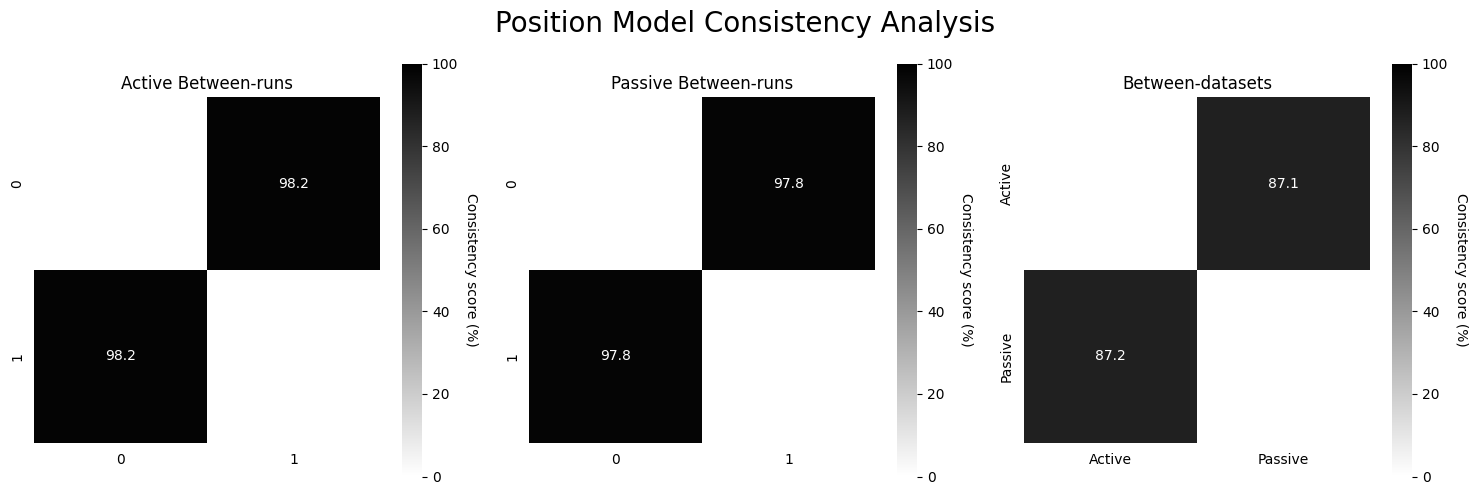

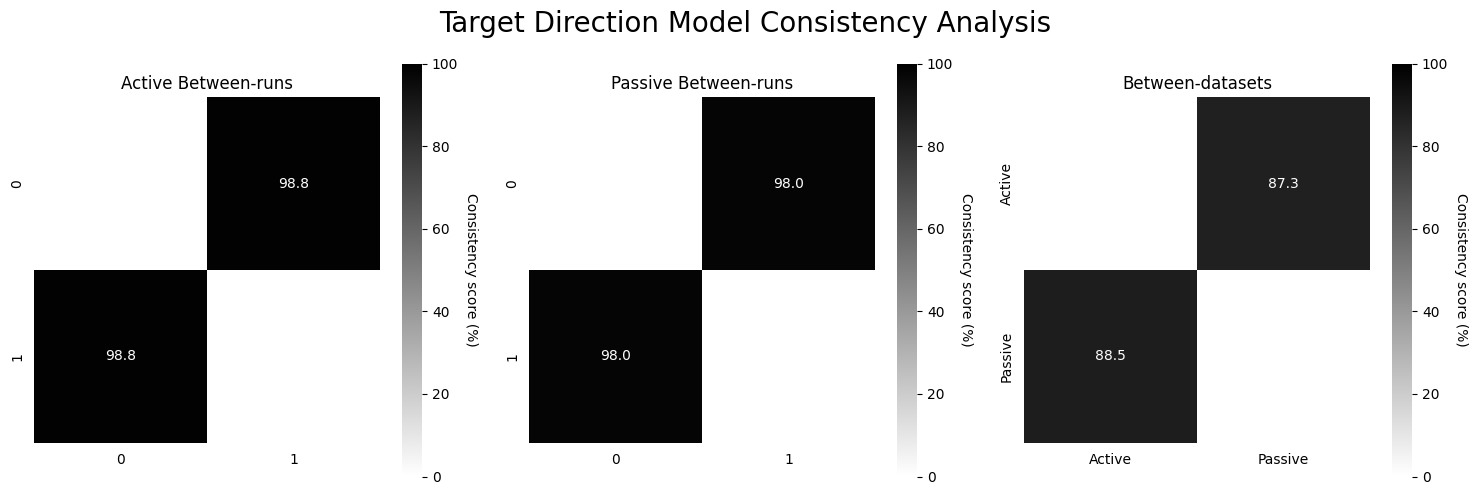

In [15]:
def plot_all_consistencies(consistency_results, title_prefix):
    """绘制所有一致性结果的可视化图"""
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f'{title_prefix} Consistency Analysis', fontsize=20)
    
    # Active运行间一致性
    ax1 = fig.add_subplot(131)
    cebra.plot_consistency(
        consistency_results['runs1'][0],
        consistency_results['runs1'][1],
        consistency_results['runs1'][2],
        ax=ax1,
        title="Active Between-runs",
        vmin=0,
        vmax=100
    )
    
    # Passive运行间一致性
    ax2 = fig.add_subplot(132)
    cebra.plot_consistency(
        consistency_results['runs2'][0],
        consistency_results['runs2'][1],
        consistency_results['runs2'][2],
        ax=ax2,
        title="Passive Between-runs",
        vmin=0,
        vmax=100
    )
    
    # 数据集间一致性
    if consistency_results['datasets'][0] is not None:
        ax3 = fig.add_subplot(133)
        cebra.plot_consistency(
            consistency_results['datasets'][0],
            consistency_results['datasets'][1],
            ["Active", "Passive"],  # 使用更有意义的标签
            ax=ax3,
            title="Between-datasets",
            vmin=0,
            vmax=100
        )
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 绘制位置模型的一致性结果
pos_consistency_fig = plot_all_consistencies(pos_consistency, "Position Model")

# 绘制目标方向模型的一致性结果
target_consistency_fig = plot_all_consistencies(target_consistency, "Target Direction Model")